# Импортируем библиотеки

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
import time
import os
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


# Чтение файлов

In [3]:
# путь к папке с данными
DATA_DIR = 'data'
PROJECT_DIR = os.getcwd()

# Список файлов
files = ['air_reserve.csv', 'air_store_info.csv', 'air_visit_data.csv', 
         'date_info.csv', 'hpg_reserve.csv', 'hpg_store_info.csv', 
         'store_id_relation.csv']

# Чтение всех CSV-файлов
for file in files:
    filepath = os.path.join(PROJECT_DIR, DATA_DIR, file)
    try:
        pd.read_csv(filepath)
        print(f"Файл '{file}' успешно загружен.")
    except FileNotFoundError:
        print(f"Ошибка: Файл '{file}' не найден.")

Файл 'air_reserve.csv' успешно загружен.
Файл 'air_store_info.csv' успешно загружен.
Файл 'air_visit_data.csv' успешно загружен.
Файл 'date_info.csv' успешно загружен.
Файл 'hpg_reserve.csv' успешно загружен.
Файл 'hpg_store_info.csv' успешно загружен.
Файл 'store_id_relation.csv' успешно загружен.


# Анализ начальных данных

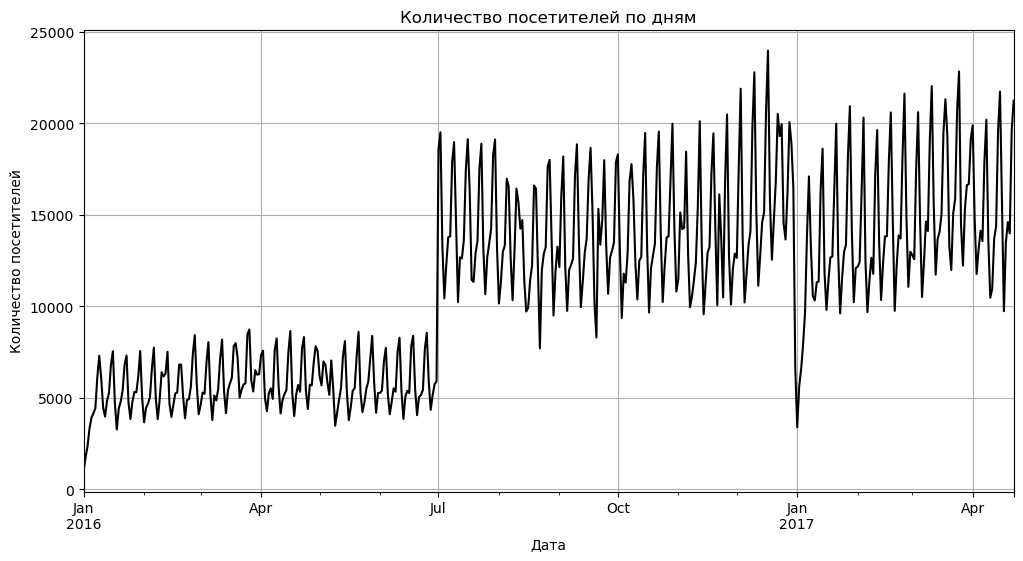

In [4]:
#читаем csv'шки
air_reserve = pd.read_csv("data/air_reserve.csv")
hpg_reserve = pd.read_csv("data/hpg_reserve.csv")
air_store_info = pd.read_csv("data/air_store_info.csv")
hpg_store_info = pd.read_csv("data/hpg_store_info.csv")
store_id_relation = pd.read_csv("data/store_id_relation.csv")
air_visit_data = pd.read_csv("data/air_visit_data.csv")
date_info = pd.read_csv("data/date_info.csv")
sample_submission = pd.read_csv('data/sample_submission.csv')
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

daily_visitors = air_visit_data.groupby('visit_date')['visitors'].sum()

plt.figure(figsize=(12, 6))
daily_visitors.plot(color='black')
plt.title('Количество посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.grid()
plt.show()

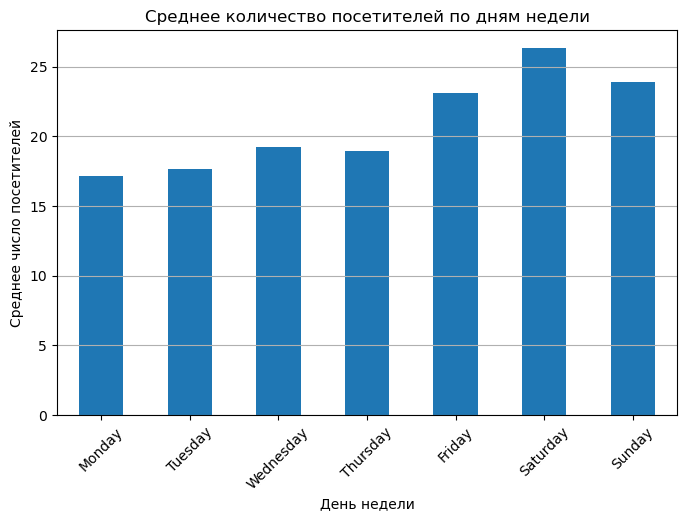

In [5]:
air_visit_data['day_of_week'] = air_visit_data['visit_date'].dt.dayofweek
visitors_by_weekday = air_visit_data.groupby('day_of_week')['visitors'].mean()

plt.figure(figsize=(8, 5))
visitors_by_weekday.plot(kind='bar')
plt.title('Среднее количество посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.xticks(ticks=range(7), labels=[calendar.day_name[i] for i in range(7)], rotation=45)
plt.grid(axis='y')
plt.show()

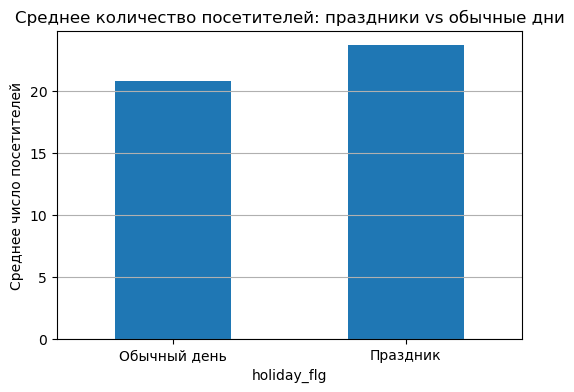

In [6]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
merged_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date')
holiday_visitors = merged_data.groupby('holiday_flg')['visitors'].mean()

plt.figure(figsize=(6, 4))
holiday_visitors.plot(kind='bar')
plt.title('Среднее количество посетителей: праздники vs обычные дни')
plt.ylabel('Среднее число посетителей')
plt.xticks(ticks=[0, 1], labels=['Обычный день', 'Праздник'], rotation=0)
plt.grid(axis='y')
plt.show()

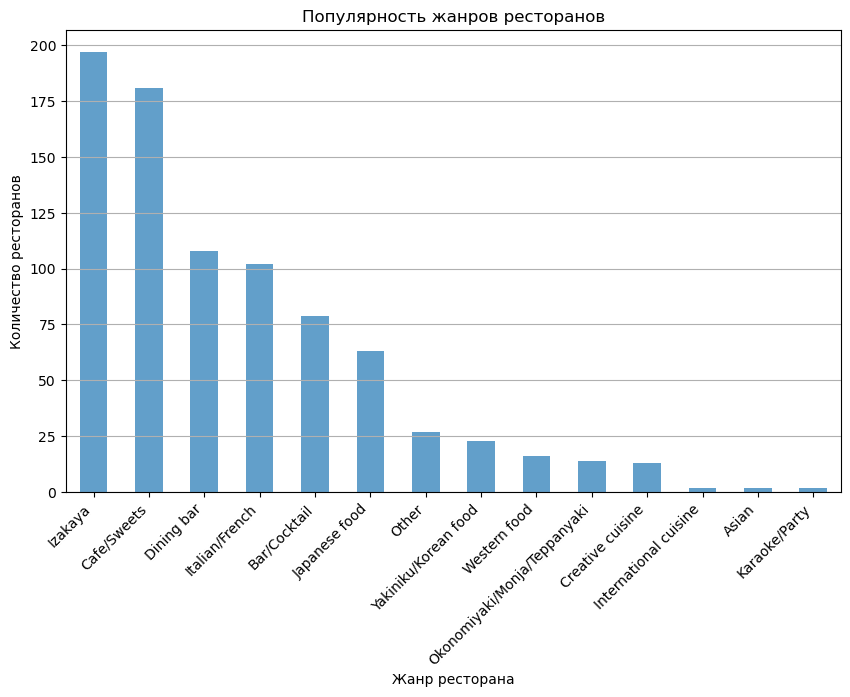

In [7]:
air_store_info = pd.read_csv("data/air_store_info.csv")
genre_counts = air_store_info['air_genre_name'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', alpha=0.7)
plt.title('Популярность жанров ресторанов')
plt.xlabel('Жанр ресторана')
plt.ylabel('Количество ресторанов')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# Подготовка данных

In [23]:
#читаем csv'шки
air_reserve = pd.read_csv("data/air_reserve.csv")
hpg_reserve = pd.read_csv("data/hpg_reserve.csv")
air_store_info = pd.read_csv("data/air_store_info.csv")
hpg_store_info = pd.read_csv("data/hpg_store_info.csv")
store_id_relation = pd.read_csv("data/store_id_relation.csv")
air_visit_data = pd.read_csv("data/air_visit_data.csv")
date_info = pd.read_csv("data/date_info.csv")
sample_submission = pd.read_csv('data/sample_submission.csv')

### Мапим в тип datetime

In [24]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])

### Мерджим таблицы, дропаем ненужные колонки
- мерджим `air_visit_data` и `date_info` по признаку даты
- дропаем `calendar_date` и добавляем новый столбец с месяцем

In [25]:
air_visit_data = air_visit_data.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)
air_visit_data = air_visit_data.drop(columns=['calendar_date'])
air_visit_data['month'] = air_visit_data['visit_date'].dt.month

### Мерджим таблицы, дропаем ненужные колонки
- мерджим `air_visit_data` и `air_store_info` по `id` магазина
- дропаем время резервирования и приводим к типу данных время посещения

In [26]:
air_visit_data = air_visit_data.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)
air_reserve = air_reserve.drop(columns=['reserve_datetime'])
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date

### Группируем
- группируем в таблице `air_reserve` `id` ресторана и дате посещения
- суммируем по количеству посетителей

In [27]:
air_reserve = air_reserve.groupby(['air_store_id', 'visit_datetime'], as_index=False, sort=False)['reserve_visitors'].sum()
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_visit_data = air_visit_data.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']], left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_datetime'], how='left'
)
air_visit_data = air_visit_data.drop(columns=['visit_datetime'])

### Заполняем нулями и unknown пустые ячейки

In [28]:
air_visit_data['reserve_visitors'] = air_visit_data['reserve_visitors'].fillna(0)
air_visit_data = air_visit_data.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)
air_visit_data['hpg_store_id'] = air_visit_data['hpg_store_id'].fillna('unknown')

### Итоговая таблица

In [29]:
air_visit_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown


### Предобработка sample_submission
- Извлекаем `air_store_id` и `visit_date` из столбца `id`.
- Преобразуем `visit_date` в формат datetime.
- Удаляем столбец `id`.

In [30]:
sample_submission['air_store_id'] = sample_submission['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission['id'].apply(lambda x: x.split('_')[-1])
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
sample_submission = sample_submission.drop(columns=['id'])

### Обработка sample_submission
1. Переносим столбец `visitors` (создаем новый).
2. Объединяем с `date_info` по дате (`visit_date` и `calendar_date`), затем удаляем `calendar_date`.
3. Добавляем столбец `month` (месяц из `visit_date`).
4. Объединяем с информацией о ресторанах (`air_store_info`) по `air_store_id`.
5. Объединяем с данными о бронированиях (`air_reserve`) по `air_store_id` и `visit_date`, заполняя пропуски в `reserve_visitors` нулями.
6. Объединяем с таблицей связей ресторанов (`store_id_relation`), заменяя пропуски в `hpg_store_id` на `'unknown'`.

In [31]:
sample_submission['visitors'] = sample_submission.pop('visitors')
sample_submission = sample_submission.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)
sample_submission = sample_submission.drop(columns=['calendar_date'])
sample_submission['month'] = sample_submission['visit_date'].dt.month

sample_submission = sample_submission.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)

sample_submission = sample_submission.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']],
    left_on=['air_store_id', 'visit_date'],
    right_on=['air_store_id', 'visit_datetime'],
    how='left'
)
sample_submission = sample_submission.drop(columns=['visit_datetime'])
sample_submission['reserve_visitors'] = sample_submission['reserve_visitors'].fillna(0)

sample_submission = sample_submission.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)

sample_submission['hpg_store_id'] = sample_submission['hpg_store_id'].fillna('unknown')

sample_submission


,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_00a91d42b08b08d9,2017-04-23,0,Sunday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
1,air_00a91d42b08b08d9,2017-04-24,0,Monday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
2,air_00a91d42b08b08d9,2017-04-25,0,Tuesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
3,air_00a91d42b08b08d9,2017-04-26,0,Wednesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
4,air_00a91d42b08b08d9,2017-04-27,0,Thursday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32015,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32016,air_fff68b929994bfbd,2017-05-29,0,Monday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32017,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown


### Очистка данных о посещениях ресторанов (air_visit_data)
1. **Очистка данных на уровне ресторанов:**
   - Для каждого ресторана (`air_store_id`) вычисляются квартильные значения (`quantile_min` и `quantile_max`) и межквартильный размах (`diff`).
   - Определяются границы выбросов: 
     - Нижняя граница: `max(0, quantile_min - 1.5 * diff)`.
     - Верхняя граница: `quantile_max + 1.5 * diff`.
   - Данные о посещаемости вне этих границ удаляются.

2. **Очистка глобальных выбросов:**
   - По очищенным данным рассчитываются глобальные `quantile_min_global`, `quantile_max_global` и `diff_global`.
   - Вычисляются глобальные границы выбросов:
     - Нижняя граница: `max(0, quantile_min_global - 1.5 * diff_global)`.
     - Верхняя граница: `quantile_max_global + 1.5 * diff_global`.
   - Данные, выходящие за эти границы, удаляются из финального набора.

3. **Результат:**
   - `cleaned_air_visit_data`: очищенные данные без локальных и глобальных выбросов.
   - `anomalies`: сохранены глобальные выбросы для возможного анализа.


In [32]:
cleaned_air_visit_data = pd.DataFrame()
for store_id, group in air_visit_data.groupby('air_store_id', as_index=False, sort=False):
    quantile_min = group['visitors'].quantile(0.25)
    quantile_max = group['visitors'].quantile(0.75)
    diff = quantile_max - quantile_min
    lower_bound = max(0, quantile_min - 1.5 * diff)
    upper_bound = quantile_max + 1.5 * diff
    cleaned_group = group[(group['visitors'] >= lower_bound) & (group['visitors'] <= upper_bound)]
    cleaned_air_visit_data = pd.concat([cleaned_air_visit_data, cleaned_group])

quantile_min_global = cleaned_air_visit_data['visitors'].quantile(0.25)
quantile_max_global = cleaned_air_visit_data['visitors'].quantile(0.75)
diff_global = quantile_max_global - quantile_min_global

lower_bound_global = max(0, quantile_min_global - 1.5 * diff_global)
upper_bound_global = quantile_max_global + 1.5 * diff_global
anomalies = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] < lower_bound_global) |
    (cleaned_air_visit_data['visitors'] > upper_bound_global)
    ]
cleaned_air_visit_data = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] >= lower_bound_global) &
    (cleaned_air_visit_data['visitors'] <= upper_bound_global)
    ]

In [33]:
print(f'Количество глобальных аномальных точек: {len(anomalies)}')
print(f'Новый размер массива данных: {len(cleaned_air_visit_data)}')
print(f'Квартиль 25% в целом: {quantile_min_global}')
print(f'Квартиль 75% в целом: {quantile_max_global}')
print(f'Межквартиль в целом: {diff_global}')
print(f'Границы отклонения в целом: [{lower_bound_global}, {upper_bound_global}]')

Количество глобальных аномальных точек: 6925
Новый размер массива данных: 240023
Квартиль 25% в целом: 9.0
Квартиль 75% в целом: 28.0
Межквартиль в целом: 19.0
Границы отклонения в целом: [0, 56.5]


In [34]:
cleaned_air_visit_data.reset_index(drop=True, inplace=True)
cleaned_air_visit_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
240018,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240019,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240020,air_24e8414b9b07decb,2017-04-20,7,Thursday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240021,air_24e8414b9b07decb,2017-04-21,8,Friday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown


In [35]:
cleaned_air_visit_data_encoded = cleaned_air_visit_data.copy().reset_index(drop=True)
cleaned_air_visit_data_merge = cleaned_air_visit_data.copy().reset_index(drop=True)

### Кодировка категориальных признаков
1. Выбраны признаки: `day_of_week`, `holiday_flg`, `month`, `air_genre_name`, `air_area_name`, `hpg_store_id`.
2. Применён `OneHotEncoder` для кодирования категорий (игнор неизвестных, drop первой категории).
3. Закодированные признаки объединены с таблицей.
4. Удалены исходные и ненужные столбцы: `air_store_id`, `visit_date`, `visitors`, `day_of_week`, `holiday_flg`, `month`, `air_genre_name`, `air_area_name`, `hpg_store_id`.

In [37]:
selected_features = cleaned_air_visit_data[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(selected_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(selected_features.columns))
cleaned_air_visit_data_encoded = pd.concat([cleaned_air_visit_data_merge, encoded_df], axis=1)
cleaned_air_visit_data_encoded = cleaned_air_visit_data_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                              'visitors', 'day_of_week',
                                                                              'holiday_flg', 'month',
                                                                              'air_genre_name', 'air_area_name',
                                                                              'hpg_store_id'])



### Кодировка категориальных признаков для тестового набора
1. Создана копия `sample_submission` в `sample_submission_encoded`.
2. Выбраны признаки для кодировки: `day_of_week`, `holiday_flg`, `month`, `air_genre_name`, `air_area_name`, `hpg_store_id`.
3. Применён `OneHotEncoder` для кодирования выбранных признаков.
4. Создан DataFrame `encoded_df_test` с закодированными признаками.
5. Объединён `sample_submission` с закодированными признаками.
6. Удалены ненужные столбцы: 
   - `air_store_id`, `visit_date`, `visitors`, 
   - `day_of_week`, `holiday_flg`, `month`, 
   - `air_genre_name`, `air_area_name`, `hpg_store_id`.

In [38]:
sample_submission_encoded = sample_submission.copy()
selected_features_test = sample_submission_encoded[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoded_features_test = encoder.fit_transform(selected_features_test)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(selected_features_test.columns))

sample_submission_encoded = pd.concat([sample_submission, encoded_df_test], axis=1)
sample_submission_encoded = sample_submission_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                    'visitors', 'day_of_week',
                                                                    'holiday_flg', 'month',
                                                                    'air_genre_name', 'air_area_name',
                                                                    'hpg_store_id'])



### Обработка отсутствующих столбцов в тестовом наборе
1. Проверка, есть ли в `sample_submission_encoded` столбцы `month_1`–`month_12` (кодированные месяцы).
2. Для отсутствующих столбцов создаются новые с значением `0.0`.
3. Приведение структуры `sample_submission_encoded` к структуре `cleaned_air_visit_data_encoded` (одинаковые столбцы).
4. Вывод информации о структурах:
   - `cleaned_air_visit_data_encoded.info()` — проверка столбцов и их типов в обучающих данных.
   - `sample_submission_encoded.info()` — проверка столбцов и их типов в тестовых данных.
5. Итоговый DataFrame `sample_submission_encoded` готов для использования.


In [40]:
missing_month_columns = [f'month_{i}' for i in range(1, 13) if f'month_{i}' not in sample_submission_encoded.columns]
for col in missing_month_columns:
    sample_submission_encoded[col] = 0.0
sample_submission_encoded = sample_submission_encoded[cleaned_air_visit_data_encoded.columns]

cleaned_air_visit_data_encoded.info()
sample_submission_encoded.info()
sample_submission_encoded


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240023 entries, 0 to 240022
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 521.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 69.6 MB


,latitude,longitude,reserve_visitors,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1,...,hpg_store_id_hpg_ee8cad9cd96718da,hpg_store_id_hpg_ef517ab154f66a8e,hpg_store_id_hpg_f07ec7b288165b27,hpg_store_id_hpg_f39996d4f0ebcb64,hpg_store_id_hpg_f76ad2d2d0134bdd,hpg_store_id_hpg_f83413cde79ac5e7,hpg_store_id_hpg_fa4eeada9ad7b59f,hpg_store_id_hpg_fbe603376b5980fc,hpg_store_id_hpg_fc892fe8d342a787,hpg_store_id_unknown
0,35.694003,139.753595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,35.694003,139.753595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,35.694003,139.753595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,35.694003,139.753595,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35.694003,139.753595,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,35.708146,139.666288,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32015,35.708146,139.666288,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32016,35.708146,139.666288,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32017,35.708146,139.666288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


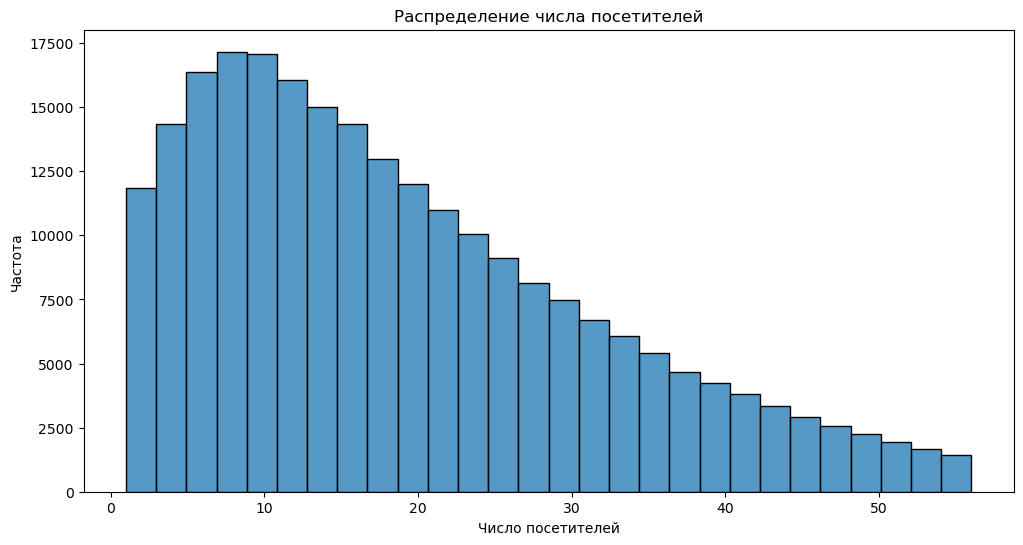

In [42]:
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_air_visit_data['visitors'], bins=28)
plt.title('Распределение числа посетителей')
plt.xlabel('Число посетителей')
plt.ylabel('Частота')
plt.show()

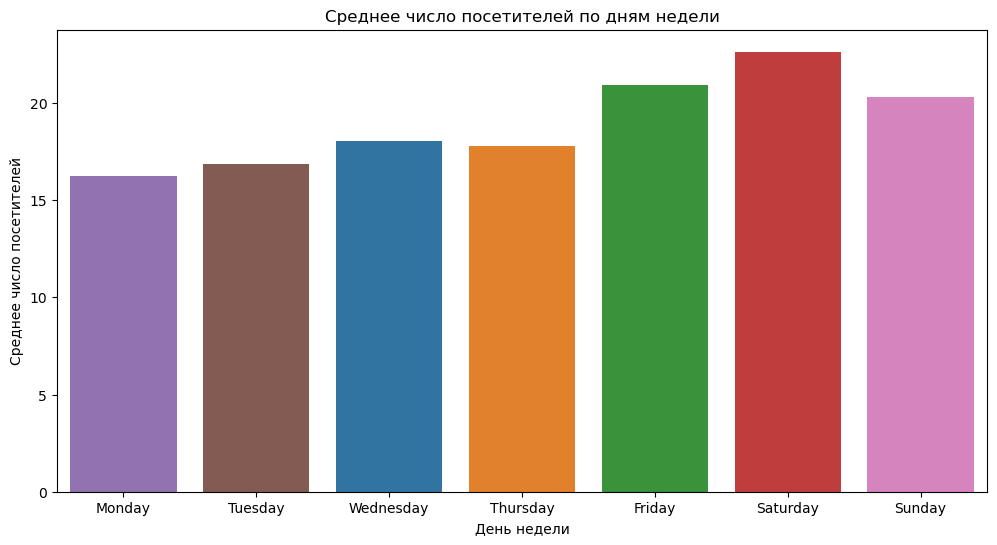

In [58]:
visitors_by_day = cleaned_air_visit_data.groupby('day_of_week', sort=False)['visitors'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='visitors', data=visitors_by_day.reset_index(), order=days, hue='day_of_week')
plt.title('Среднее число посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.show()

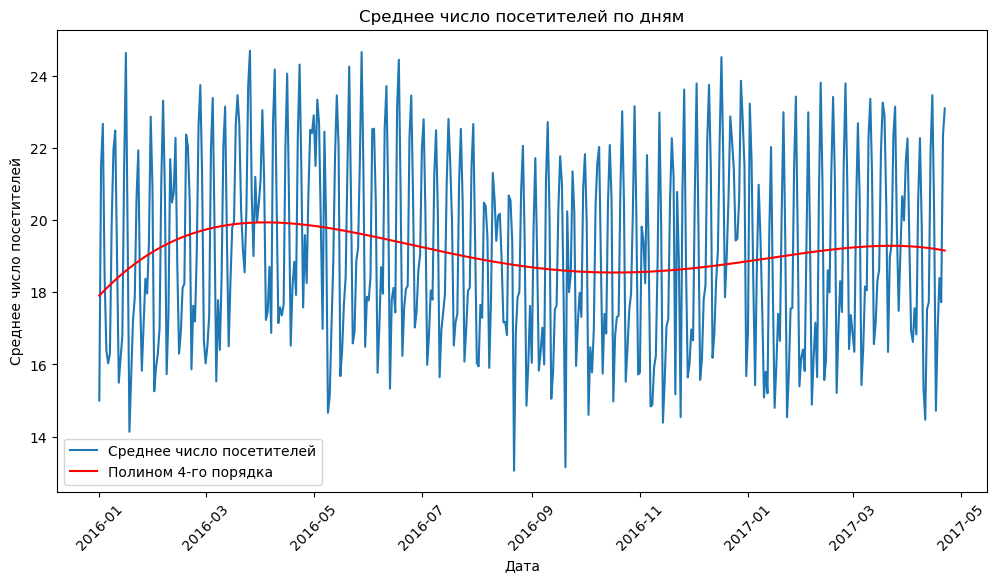

In [60]:
avg_visitors = cleaned_air_visit_data.groupby('visit_date')['visitors'].mean().reset_index()
avg_X = (avg_visitors['visit_date'] - avg_visitors['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors['visitors']
polynom = PolynomialFeatures(degree=4)
polynom_X = polynom.fit_transform(avg_X)
model = LinearRegression()
model.fit(polynom_X, avg_y)
polynom_pred_y = model.predict(polynom_X)
plt.figure(figsize=(12, 6))
plt.plot(avg_visitors['visit_date'], avg_visitors['visitors'], label='Среднее число посетителей')
plt.plot(avg_visitors['visit_date'], polynom_pred_y, color='red', label='Полином 4-го порядка')
plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Разделение данных
- Признаки: `X_train = cleaned_air_visit_data_encoded`.
- Цель: `y_train = cleaned_air_visit_data['visitors']`.
- 70% в `X_train_split`, `y_train_split`, 30% в `X_val_split`, `y_val_split`.


In [47]:
X_train = cleaned_air_visit_data_encoded
y_train = cleaned_air_visit_data['visitors']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

модель LR начала обучение
модель LR закончила обучение
модель LR начала предикшн
модель LR закончила предикшн
модель XGBR начала обучение
модель XGBR закончила обучение
модель XGBR начала предикшн
модель XGBR закончила предикшн
модель RFR начала обучение
модель RFR закончила обучение
модель RFR начала предикшн
модель RFR закончила предикшн
модель GBR начала обучение
модель GBR закончила обучение
модель GBR начала предикшн
модель GBR закончила предикшн
модель ETR начала обучение
модель ETR закончила обучение
модель ETR начала предикшн
модель ETR закончила предикшн
модель ABR начала обучение
модель ABR закончила обучение
модель ABR начала предикшн
модель ABR закончила предикшн
модель Ridge начала обучение
модель Ridge закончила обучение
модель Ridge начала предикшн
модель Ridge закончила предикшн
модель Lasso начала обучение
модель Lasso закончила обучение
модель Lasso начала предикшн
модель Lasso закончила предикшн
модель EN начала обучение
модель EN закончила обучение
модель EN начала 

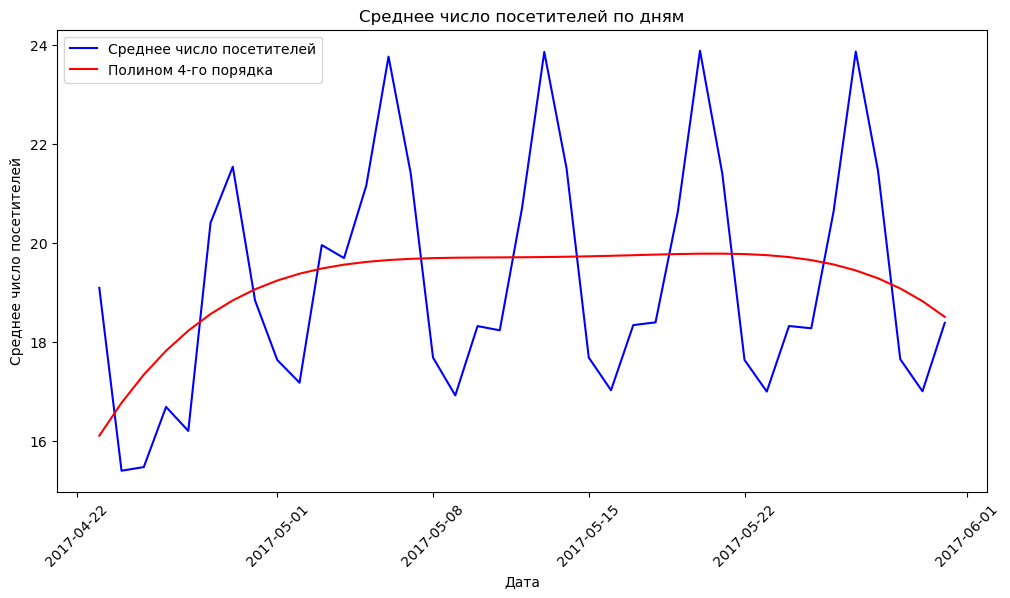

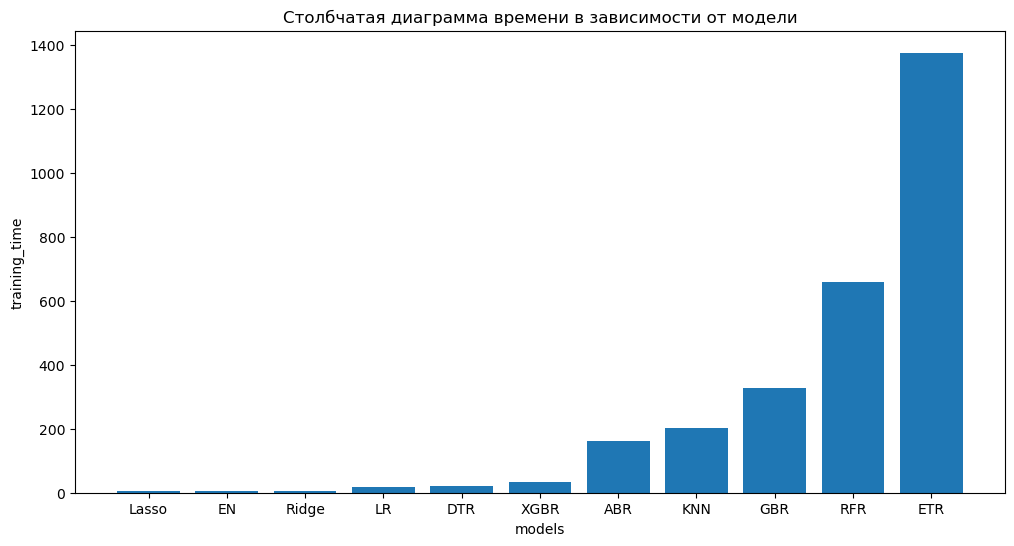

In [57]:
#модели
models = {
    "LR": LinearRegression(),
    "XGBR": XGBRegressor(objective='reg:squarederror', random_state=42),
    'RFR': RandomForestRegressor(random_state=42),
    'GBR': GradientBoostingRegressor(random_state=42),
    'ETR': ExtraTreesRegressor(random_state=42),
    'ABR': AdaBoostRegressor(random_state=42),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'EN': ElasticNet(),
    'DTR': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}
#Подбираем гиперпараметры - для XGBoost- вручную
gyper_parameters = {
    "LR": {},
    "XGBR": {
        'n_estimators': [200],
        'learning_rate': [0.6],
        'max_depth': [8]
    },
    "RFR": {
        'n_estimators': [100],
        'n_jobs' : [-1]
    },
    'GBR':{
        'n_estimators': [100]
    },
    'ETR':{
        'n_estimators': [100], 
        'n_jobs': [-1]
    },
    'ABR':{
        'n_estimators': [100]
    },
    'Ridge':{
        'alpha': [1.0]
    },
    'Lasso': {
        'alpha': [1.0]
    },
    'EN': {
        'alpha': [1.0], 
        'l1_ratio': [0.5]
    },
    'DTR':{},
    'KNN':{
        'n_neighbors': [5]
    }
}

mae_scores = {}
mape_scores = {}
training_times = {}

for name, model in models.items():
    start_time = time.time()
    #Создаем объект GridSearchCV, в котором есть модель и набор гиперпараметров
    grid_search = GridSearchCV(estimator=model, param_grid=gyper_parameters[name])
    print(f"модель {name} начала обучение")
    grid_search.fit(X_train_split, y_train_split)#Обучаем
    print(f"модель {name} закончила обучение")
    print(f"модель {name} начала предикшн")
    y_val_pred = grid_search.predict(X_val_split)#предикт
    print(f"модель {name} закончила предикшн")
    end_time = time.time()
    training_times[name] = end_time - start_time
    mae_scores[name] = mean_absolute_error(y_val_split, y_val_pred) # Cредняя абсолютная ошибка
    mape = mean_absolute_percentage_error(y_val_split, y_val_pred)* 100 # средняя абсолютная ошибка в процентах
    mape_scores[name] = mape 



#Сортируем ошибки по возрастанию
sorted_scores = sorted(mae_scores.items(), key=lambda x: x[1])

print("Средние абсолютные ошибки моделей:")
for model, score in sorted_scores:
    print(f"{model}: MAE = {score:.4f}, MAPE = {mape_scores[model]:.2f}%")



# Сортировка словаря по значениям
sorted_training_times = dict(sorted(training_times.items(), key=lambda item: item[1]))

# график по коэффициенту эффективности
plt.figure(figsize=(12, 6))
plt.bar(list(sorted_training_times.keys()), list(sorted_training_times.values()))
plt.xlabel("models")
plt.ylabel("training_time")
plt.title("Столбчатая диаграмма времени в зависимости от модели")
plt.show()

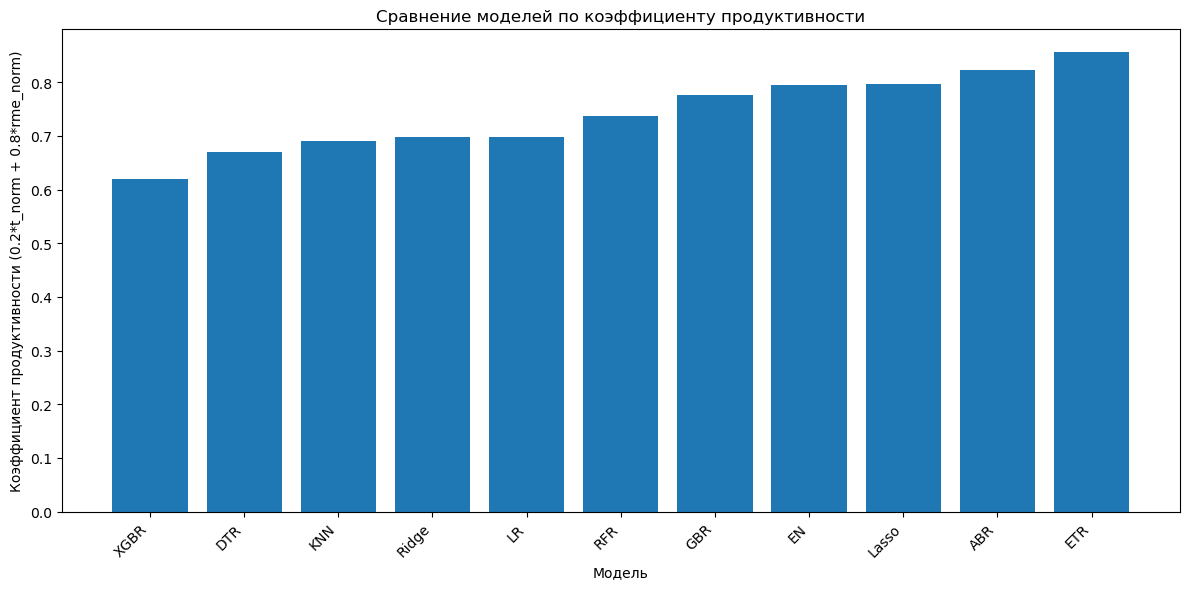

In [61]:
# Блок нормализации и построения графика
max_time = max(training_times.values())
max_mae = max(mae_scores.values())

normalized_results = {}
for name, model in models.items():
    normalized_results[name] = {
        'efficiency': 0.2 * training_times[name] / max_time + 0.8 * mae_scores[name] / max_mae
    }
    
models_to_efficiency_map = {}

for k in normalized_results:
    models_to_efficiency_map[k] = normalized_results[k]['efficiency']

sorted_models_to_efficiency_map = dict(sorted(models_to_efficiency_map.items(), key=lambda x:x[1]))

plt.figure(figsize=(12, 6))
plt.bar(list(sorted_models_to_efficiency_map.keys()), sorted_models_to_efficiency_map.values())
plt.xlabel("Модель")
plt.ylabel("Коэффициент продуктивности (0.2*t_norm + 0.8*rme_norm)")
plt.title("Сравнение моделей по коэффициенту продуктивности")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 49 candidates, totalling 245 fits
Лучшие параметры: {'n_estimators': np.int32(285), 'max_depth': np.int32(5), 'learning_rate': np.float64(0.7682550784910228)}, MAE: 8.068923894108854


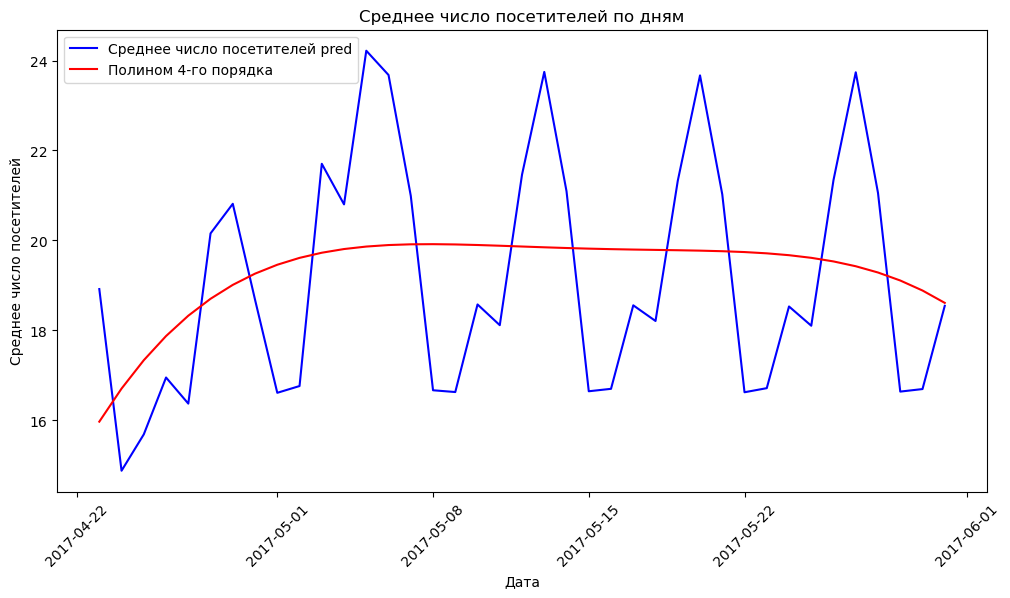

In [76]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': np.random.randint(50, 300, 7),
    'learning_rate': np.random.uniform(0.01, 0.9, 7),
    'max_depth': np.random.randint(5, 12, 7)
}

model = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=49,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, 
)

random_search.fit(X_train_split, y_train_split)

results = {}
for i, (params, mean_score) in enumerate(zip(random_search.cv_results_['params'],
                                             -random_search.cv_results_['mean_test_score'])):
    y_val_pred = random_search.predict(X_val_split)
    mae = mean_absolute_error(y_val_split, y_val_pred)
    results[tuple(sorted(params.items()))] = mae # ключ - упорядоченный кортеж параметров

print(f"Лучшие параметры: {random_search.best_params_}, MAE: {-random_search.best_score_}")

best_model = random_search.best_estimator_

#Обучаем лучшую модель на всей обучающей выборке
best_model.fit(X_train, y_train)

#Используем тестовую выборку
X_test = sample_submission_encoded
y_test_pred = best_model.predict(X_test)


sample_submission['visitors']=y_test_pred
avg_visitors_pred = sample_submission.groupby('visit_date')['visitors'].mean().reset_index()
avg_X = (avg_visitors['visit_date'] - avg_visitors['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors['visitors']
polynom = PolynomialFeatures(degree=4)
polynom_X = polynom.fit_transform(avg_X)
model = LinearRegression()
model.fit(polynom_X, avg_y)
polynom_pred_y = model.predict(polynom_X)

plt.figure(figsize=(12, 6))
plt.plot(avg_visitors['visit_date'], avg_visitors_pred['visitors'], color='blue', label='Среднее число посетителей pred')
plt.plot(avg_visitors['visit_date'], polynom_pred_y, color='red', label='Полином 4-го порядка')
plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.show()
